# Small Image Search Engine

### Plan 
- idea: small search engine. You input an image and the engine should return 5 similar images
- use vgg weights, i.e. a pretrained model
- download an image data set like image-net, just 3000 images
- Flow:
    - pass all the images through the neural network but not until the end with all the dense layers, but only the feature extractor to get a feature map
    - by feature map we mean, like a multidimensional space in which each image is a point
    - when we use the search engine with a new image, it means we will use this multidimensional space to search for the closest points using a euclidean distance

---
It worked! 
TODO: since the images have low resolution I conjecture that is the reason it sometimes perfoms badly but in most cases the first two are close

(1000, 32, 32, 3)


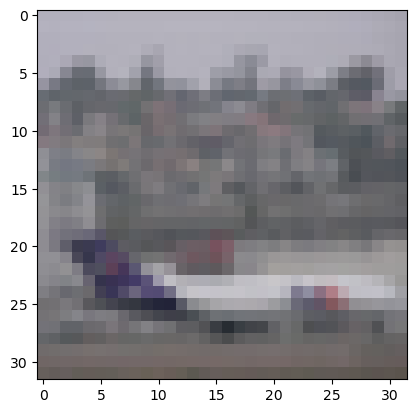

In [1]:
# Some data processing 

import tarfile
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch 

path = 'test_sets/cifar-10-python.tar.gz'
images = []

# Helper function to unpickle CIFAR-10 binary data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

with tarfile.open(path, "r:gz") as tar:
    for member in tar.getmembers():
        if 'data_batch' in member.name:  # Load only the data batches (ignore metadata, etc.)
            f = tar.extractfile(member)
            if f is not None:
                content = f.read()
                batch = pickle.loads(content, encoding='bytes')
                images.append(batch[b'data'])  # CIFAR-10 images are in the 'data' field

# Stack all the image arrays and reshape
images = np.vstack(images)[:1000]
images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
print(images.shape)  # This should print (number of images, 32, 32, 3)
images = torch.tensor(images)
plt.imshow(images[0])

In [2]:
# load the weights of the vgg11 model. pretrained model 

from torchvision import models

# min_size
# height=32, width=32
model = models.vgg11(weights='DEFAULT')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [3]:
# we are interested in the layer prior to the linear layers, so we use a feature map 

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

train_nodes, eval_nodes = get_graph_node_names(model)
print(train_nodes)
print(eval_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [4]:
feature_map = create_feature_extractor(model, {'flatten':'flatten'})
pos_processing = create_feature_extractor(model, {'classifier.6':'classifier.6'})
print(feature_map)
print('---------------------------------------------------------------------------------------')
print(pos_processing)

VGG(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

In [5]:
feature_map.eval()

with torch.no_grad():
    lst = [(feature_map(image.unsqueeze(0).permute(0, 3, 1, 2).float())['flatten'].numpy(), smt) for smt,image in enumerate(images[:900])]
print(len(lst))

900


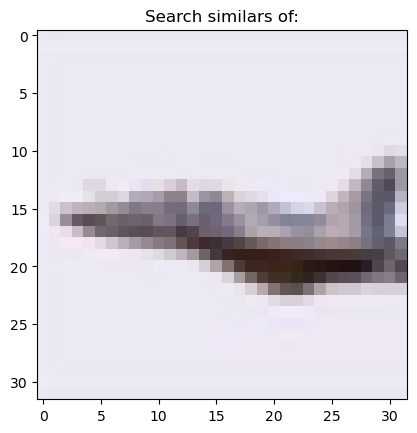

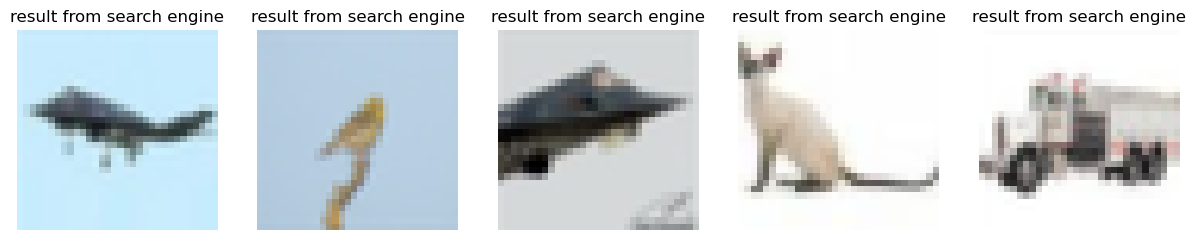

In [17]:
# we can play with images from 901 to 1000
idx = 968
with torch.no_grad():
    image_to_search = images[idx]
    out_data = feature_map(image_to_search.unsqueeze(0).permute(0, 3, 1, 2).float())['flatten'].numpy()
    plt.title('Search similars of:')
    plt.imshow(image_to_search)

    # compute the euclidean distance
    eucl = [(np.sqrt(np.sum((l1-out_data)**2)),id) for l1, id in lst]

    # grab the best 5 matches
    returned_possible_matches= sorted(eucl, key=lambda x: x[0])

    indexes = [idx for _,idx in returned_possible_matches[:5]]

    # Assuming images[indexes] has shape (T, 32, 32, 3)
    matched_images = images[indexes]  # No need to permute if the shape is already correct

    # Create a subplot with 1 row and 5 columns
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    # Display each image in a separate subplot
    for i in range(5):
        axes[i].imshow(matched_images[i].cpu().numpy())  # Convert tensor to numpy array
        axes[i].axis('off')  # Hide the axes for better visualization
        axes[i].set_title('result from search engine')

    plt.show()
